In [1]:
import json
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

from textstat.textstat import textstat

%matplotlib inline

### Loading data for selection

In [2]:
considered_samples = 100000
values_per_label = 10000

In [3]:
columns_full = ['title', 'keywords', 'readingTime', 'text']
columns = ['title', 'keywords', 'readingTime', 'text', 'num_images', 'num_tags', 'count_tag_fol', 
           'count_tag_posts', 'weekday', 'seconds', 'count_words', 'FK_grade']

def get_short_info(obj):
    return [obj['likes']]

def get_full_info(obj):
    res = []
    for col in columns_full:
        if col == 'keywords':
            res.append(' '.join(obj[col]))
        else:
            res.append(obj[col])
            
    res.append(len(obj['images']))
    res.append(len(obj['tags']))
    res.append(sum(list(map(lambda x: x['followerCount'], obj['tags']))))
    res.append(sum(list(map(lambda x: x['postCount'], obj['tags']))))
    
    date = datetime.datetime.fromtimestamp(float(obj['date']['$numberLong'])/1000.)
    res.append(date.weekday())
    res.append(date.hour*60*60 + date.minute*60 + date.second)
    res.append(len(obj['text'].split(' ')))
    try:
        if obj['text'] != '' and obj['text'] is not None:
            res.append(textstat.flesch_kincaid_grade(obj['text']))
        else:
            res.append(0)
    except Exception as e:
        res.append(0)
        
    ###############################################
    ## If you want to append some extra features ##
    ##      there is the best place for them     ##
    ###############################################
                
    return res

data = []
ind = []

for i, l in enumerate(open('data/medium.json')):
    obj = json.loads(l)
    ind.append(obj['id'])
    data.append(get_short_info(obj))
    if len(data) > considered_samples:
        break

In [4]:
df = pd.DataFrame(data, index=ind, columns=['likes'])

df['group'] = 0
borders = [1e-20, 2, 4, np.inf]

print(len(df[df.likes == 0]))

bins = [df[df.likes == 0].sample(values_per_label, replace=True)]
for i in range(1, len(borders)):
    ins = np.logical_and(np.log1p(df.likes) < borders[i], np.log1p(df.likes) >= borders[i-1])
    print(len(df[ins]))
    df.loc[ins, 'group'] = i
    bins.append(df[ins].sample(values_per_label, replace=True))
    
df = pd.concat(bins)

23407
52742
16466
7386


In [5]:
ind = df.index
new_info = {}

count = 0
for i, l in enumerate(open('data/medium.json')):
    obj = json.loads(l)
    if i > considered_samples:
        break
    if i % 1000 == 0:
        print('.', end='')
    if obj['id'] in ind and obj['id'] not in new_info:
        new_info[obj['id']] = get_full_info(obj)

..............Error(ASyPW): Number of words are zero, cannot divide
..............................................................Error(ASyPW): Number of words are zero, cannot divide
..Error(ASyPW): Number of words are zero, cannot divide
......Error(ASyPW): Number of words are zero, cannot divide
.Error(ASyPW): Number of words are zero, cannot divide
................

In [6]:
new_df = pd.DataFrame.from_dict(new_info, orient='index')
new_df.columns = columns
df = pd.merge(df, new_df, 'inner', left_index=True, right_index=True)

df.head()

,likes,group,title,keywords,readingTime,text,num_images,num_tags,count_tag_fol,count_tag_posts,weekday,seconds,count_words,FK_grade
100134efc717,0,0,iOS İçin Yeni Bir Assassin’s Creed Oyunu Göründü!,Ubisoft,0.226415,"Ubisoft,Assasin’s Creed oyununu farklı platfor...",0,1,7,288,2,52421,50,13.2
100134efc717,0,0,iOS İçin Yeni Bir Assassin’s Creed Oyunu Göründü!,Ubisoft,0.226415,"Ubisoft,Assasin’s Creed oyununu farklı platfor...",0,1,7,288,2,52421,50,13.2
10064c2cabe2,36,2,The Day I Stayed Seated,Music Piano Divorce Memoir High School,3.196226,I learned to stand for myself the day I stayed...,1,5,179046,22280,0,78779,775,5.1
100c86196d23,0,0,Dubai business directory may be the answer to ...,Dubai Business Directory Business Directory,1.656604,Being in a city that is known for its infrastr...,0,2,2,48,2,31311,424,12.0
100c86196d23,0,0,Dubai business directory may be the answer to ...,Dubai Business Directory Business Directory,1.656604,Being in a city that is known for its infrastr...,0,2,2,48,2,31311,424,12.0


### Prepare text features

In [7]:
all_texts = np.hstack([df.text.values,df.title.values,df.keywords])

# Hashing Vectorizer
# from sklearn.feature_extraction.text import HashingVectorizer
# hv = HashingVectorizer(ngram_range=(1,3), n_features=2**13)
# text_features = hv.fit_transform(all_texts)

# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
hv = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
text_features = hv.fit_transform(all_texts)


(120000, 10000)

In [8]:
text_tokens = text_features[:values_per_label*4]
title_tokens = text_features[values_per_label*4:8*values_per_label]
keywords_tokens = text_features[8*values_per_label:]

### Train/test splitting

In [9]:
indexes = df.index.values
target = df.group.values.astype('int8')

num_cols = ['readingTime', 'num_images', 'num_tags', 'count_tag_fol', 'count_tag_posts', 'weekday', 'seconds', 'count_words','FK_grade']
df_non_text = df[num_cols].values.astype('float32')

In [10]:
from sklearn.model_selection import train_test_split
data_tuple = train_test_split(indexes,title_tokens,text_tokens,keywords_tokens,df_non_text,target)

ind_tr,ind_ts,title_tr,title_ts,text_tr,text_ts,keyw_tr,keyw_ts,nontext_tr,nontext_ts,target_tr,target_ts = data_tuple

### Save (load) progress

In [11]:
import pickle

# Save

with open("preprocessed_data_td.pcl",'wb') as fout:
    pickle.dump(data_tuple,fout)

# Load

# with open("preprocessed_data_rf.pcl",'rb') as fin:
#     data_tuple = pickle.load(fin)
# ind_tr,ind_ts,title_tr,title_ts,text_tr,text_ts,keyw_tr,keyw_ts,nontext_tr,nontext_ts,target_tr,target_ts = data_tuple


### Model Stuff

In [12]:
X_train = np.hstack([nontext_tr, title_tr.toarray(), text_tr.toarray(), keyw_tr.toarray()])
y_train = target_tr

X_test = np.hstack([nontext_ts, title_ts.toarray(), text_ts.toarray(), keyw_ts.toarray()])
y_test = target_ts

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((30000, 30009), (30000,), (10000, 30009), (10000,))

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[150, 200, 250, 300]
}

gcv = GridSearchCV(RandomForestClassifier(class_weight='balanced', max_depth=None), params, verbose=2, cv=3)
gcv.fit(X_train, y_train)

# rf = RandomForestClassifier(n_estimators=100, max_depth=10, max_features='sqrt', class_weight='balanced')
# rf.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] n_estimators=150 ................................................
[CV] ....................................... n_estimators=150 -   6.4s
[CV] n_estimators=150 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.1min remaining:    0.0s


[CV] ....................................... n_estimators=150 -   6.2s
[CV] n_estimators=150 ................................................
[CV] ....................................... n_estimators=150 -   7.5s
[CV] n_estimators=200 ................................................
[CV] ....................................... n_estimators=200 -   9.6s
[CV] n_estimators=200 ................................................
[CV] ....................................... n_estimators=200 -   7.7s
[CV] n_estimators=200 ................................................
[CV] ....................................... n_estimators=200 -   6.5s
[CV] n_estimators=250 ................................................
[CV] ....................................... n_estimators=250 -   6.4s
[CV] n_estimators=250 ................................................
[CV] ....................................... n_estimators=250 -   8.9s
[CV] n_estimators=250 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 106.6min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [150, 200, 250, 300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=2)

In [14]:
rf = gcv.best_estimator_
# rf.fit(X_train, y_train)
rf

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

AUC: ['0.894', '0.818', '0.858', '0.951']
PR AUC: ['0.790', '0.603', '0.726', '0.906']
Confusion matrix
[[ 0.67078517  0.19888402  0.06656038  0.06377043]
 [ 0.2155277   0.49656288  0.1378892   0.15002022]
 [ 0.0768      0.2096      0.5116      0.202     ]
 [ 0.01191422  0.05559968  0.06592534  0.86656076]]


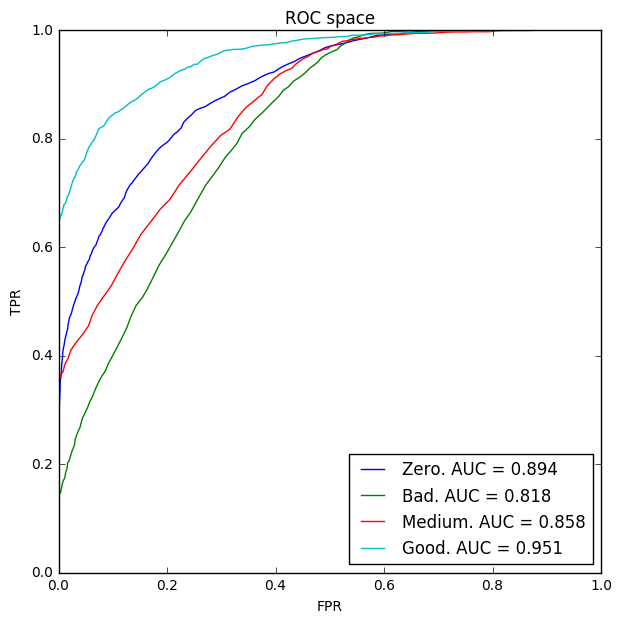

In [15]:
from sklearn.metrics import precision_recall_curve, roc_auc_score, auc, confusion_matrix, roc_curve

def pr_auc(y_true, y_pred):
    pr, rec, _ = precision_recall_curve(y_true, y_pred)
    return '%.3f' % auc(rec, pr)


y_pred = rf.predict_proba(X_test)
print('AUC:', ['%.3f' % roc_auc_score(y_test == i, y_pred[:,i]) for i in range(4)])
print('PR AUC:',[pr_auc(y_test == i, y_pred[:,i]) for i in range(4)])

print('Confusion matrix')
cm = confusion_matrix(y_test, np.argmax(y_pred, axis=1))
print(cm/cm.sum(axis=1).reshape(-1,1))

classes = ['Zero', 'Bad', 'Medium', 'Good']
plt.figure(figsize=(7,7))
for i in range(4):
    fpr, tpr, _ = roc_curve(y_test == i, y_pred[:,i])
    plt.plot(fpr, tpr, label = classes[i] + '. AUC = %.3f' % roc_auc_score(y_test == i, y_pred[:,i]))
plt.legend(loc='best')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC space');

In [16]:
print('AUC:', ['%.3f' % roc_auc_score(y_test == i, y_pred[:,i]) for i in range(4)])
print('PR AUC:',[pr_auc(y_test == i, y_pred[:,i]) for i in range(4)])

AUC: ['0.894', '0.818', '0.858', '0.951']
PR AUC: ['0.790', '0.603', '0.726', '0.906']


In [17]:
# 200, 20
print('AUC:', ['%.3f' % roc_auc_score(y_test == i, y_pred[:,i]) for i in range(4)])
print('PR AUC:',[pr_auc(y_test == i, y_pred[:,i]) for i in range(4)])

AUC: ['0.894', '0.818', '0.858', '0.951']
PR AUC: ['0.790', '0.603', '0.726', '0.906']


In [18]:
print(pd.DataFrame(cm/cm.sum(axis=1).reshape(-1,1)).to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &         0 &         1 &         2 &         3 \\
\midrule
0 &  0.670785 &  0.198884 &  0.066560 &  0.063770 \\
1 &  0.215528 &  0.496563 &  0.137889 &  0.150020 \\
2 &  0.076800 &  0.209600 &  0.511600 &  0.202000 \\
3 &  0.011914 &  0.055600 &  0.065925 &  0.866561 \\
\bottomrule
\end{tabular}



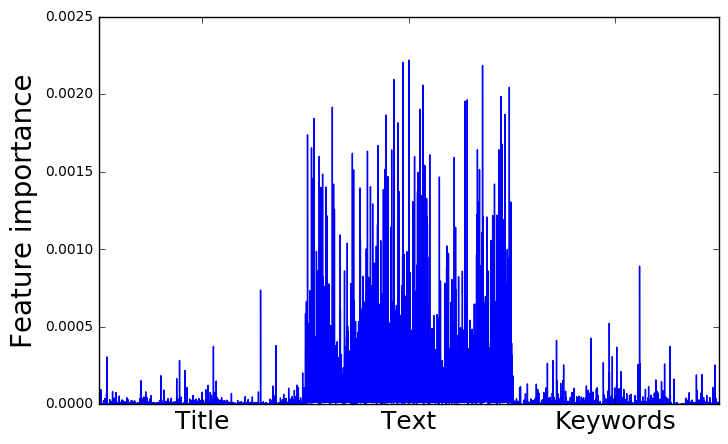

In [19]:
plt.figure(figsize=(8,5))
plt.plot(rf.feature_importances_[len(num_cols):])
plt.ylabel('Feature importance', fontsize=20)
# plt.xticks([4096, 12288, 20480], ['Title', 'Text', 'Keywords'], fontsize=18);
plt.xticks([5000, 15000, 25000], ['Title', 'Text', 'Keywords'], fontsize=18);

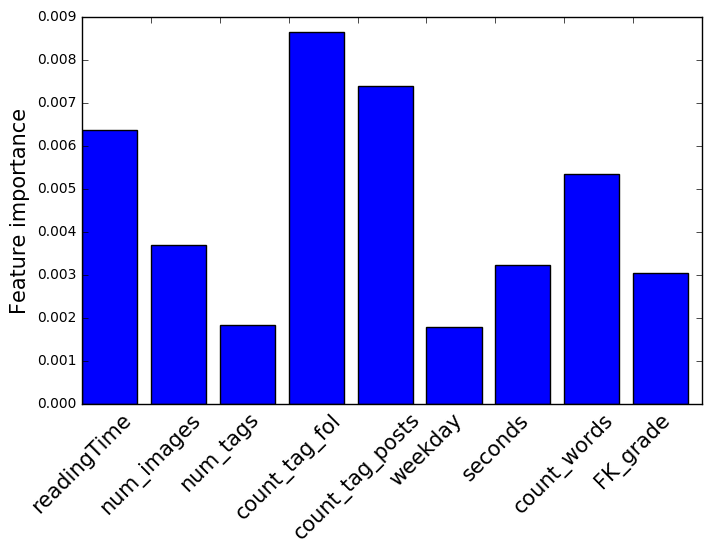

In [20]:
plt.figure(figsize=(8,5))
ind = np.arange(len(num_cols))
plt.bar(np.arange(len(num_cols)), rf.feature_importances_[:len(num_cols)])
plt.ylabel('Feature importance', fontsize=15)
plt.xticks(np.arange(0, len(num_cols)+1, 1), num_cols, rotation=45, fontsize=15);